In [9]:
import sdeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [7]:
%matplotlib inline

# Agenda

- Reminders
- Strong convergence vs Weak convergence
- Euler-Maruyama and Milstein Method
- Runge-Kutta Methods
- Verlet Algorithm
- Exact Algorithm by Beskos et al.

# Reminders

1. Itô process
2. Itô lemma

## Itô process




## Itô's lemma


# Convergence

### Strong convergence

The strong order of convergence is defined to be the largest exponent $\gamma$ such that if we numerically solve and SDE using $M = 1 / \Delta t$ steps of size $\Delta t$, then there exists a constant $K$ such that 
$$
\mathrm{E}[\vert \mathbf{x}(t_M) - \mathbf{\hat{x}}(t_M)\vert] \leq K \Delta t^{\gamma}
$$

### Weak convergence

The weak order of convergence is the largest exponent $\alpha$ such that 
$$
\left|\mathrm{E}\left[g\left(\mathbf{x}\left(t_{M}\right)\right)\right]-\mathrm{E}\left[g\left(\hat{\mathbf{x}}\left(t_{M}\right)\right)\right]\right| \leq K \Delta t^{\alpha},
$$
for any polynomial $g$. Note that for for the weak convergence we only need to approximate the distribution.

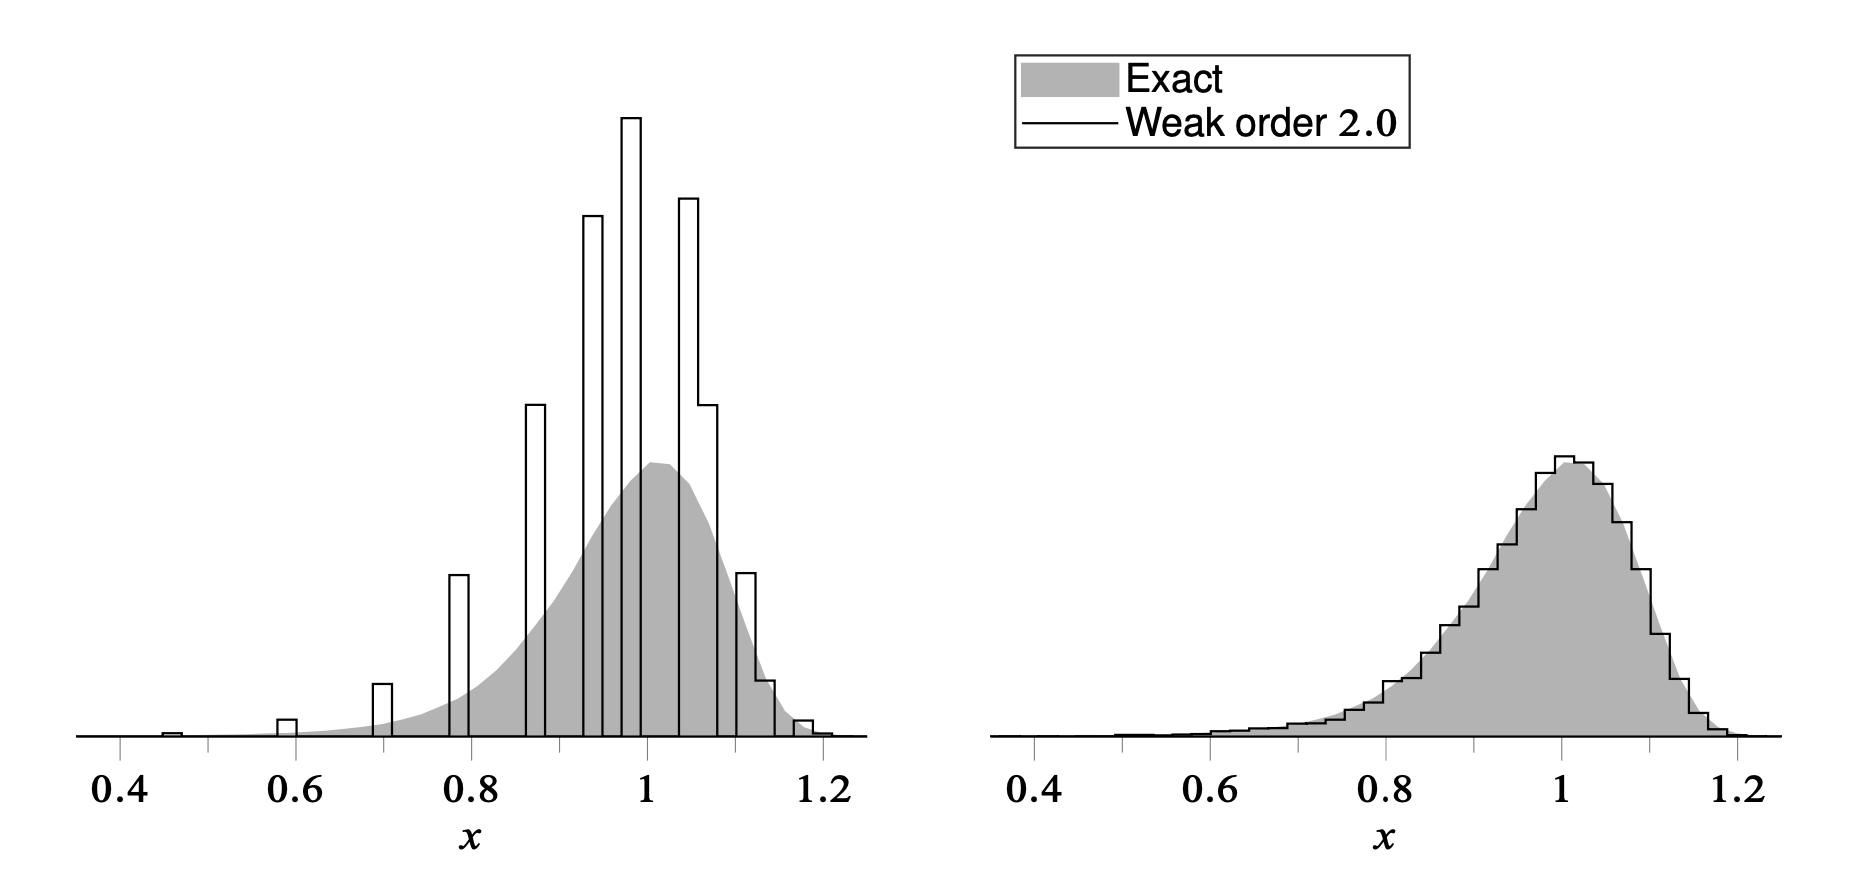

Under the _weak convergence_ criterion, the two solutions would have very similar error.

# Euler-Maruyama and Milstein methods

## Main derivations

## Euler-Maruyama

## Milstein Method

## Demonstration

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)



# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

In [31]:
HTML(anim.to_html5_video())

## Empirical estimate of _strong_ and _weak_ convergence order

# Runge-Kutta methods

1. Motivation
2. Ordinary Runge-Kutta
3. Stochastic Runge-Kutta Methods

## Motivation

Milstein method requires partial derivatives of $\mathbf{f}(\mathbf{x}(t_0), t_0)$ with respect to each of $x_i$'s and time $t$.

## Ordinary Runge-Kutta

Consider the following ODE:

$$
\frac{\mathrm{d} \mathbf{x}(t)}{\mathrm{d} t}=\mathbf{f}(\mathbf{x}(t), t), \quad \mathbf{x}\left(t_{0}\right)=\mathbf{x}_{0}
$$

### Fourth-order Runge-Kutta

$$
\begin{aligned}
\Delta \mathbf{x}_{k}^{1} &=\mathbf{f}\left(\hat{\mathbf{x}}\left(t_{k}\right), t_{k}\right) \Delta t \\
\Delta \mathbf{x}_{k}^{2} &=\mathbf{f}\left(\hat{\mathbf{x}}\left(t_{k}\right)+\Delta \mathbf{x}_{k}^{1} / 2, t_{k}+\Delta t / 2\right) \Delta t \\
\Delta \mathbf{x}_{k}^{3} &=\mathbf{f}\left(\hat{\mathbf{x}}\left(t_{k}\right)+\Delta \mathbf{x}_{k}^{2} / 2, t_{k}+\Delta t / 2\right) \Delta t \\
\Delta \mathbf{x}_{k}^{4} &=\mathbf{f}\left(\hat{\mathbf{x}}\left(t_{k}\right)+\Delta \mathbf{x}_{k}^{3}, t_{k}+\Delta t\right) \Delta t
\end{aligned}
$$

$$
\hat{\mathbf{x}}\left(t_{k+1}\right)=\hat{\mathbf{x}}\left(t_{k}\right)+\frac{1}{6}\left(\Delta \mathbf{x}_{k}^{1}+2 \Delta \mathbf{x}_{k}^{2}+2 \Delta \mathbf{x}_{k}^{3}+\Delta \mathbf{x}_{k}^{4}\right)
$$

The corresponding Butcher's tableau is
$$
\begin{array}{c|cccc}
0 & & & & \\
\frac{1}{2} & \frac{1}{2} & & & \\
\frac{1}{2} & 0 & \frac{1}{2} & & \\
1 & 0 & 0 & 1 & \\
\hline & \color{red}{\frac{1}{6}} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6}
\end{array}
$$




$$
\begin{array}{c|cccc}
c_{1} & A_{1,1} & & & \\
c_{2} & A_{2,1} & A_{2,2} & & \\
\vdots & \vdots & & \ddots & \\
c_{s} & A_{s, 1} & A_{s, 2} & \ldots & A_{s, s} \\
\hline & \alpha_{1} & \alpha_{2} & \ldots & \alpha_{s}
\end{array}
$$



# Verlet Algorithm

- Solving 2nd order stochastic SDEs

# Exact Algorithm

# References

- Applied Stochastic Differential Equations by Särkkä and Solin, CUP  2019
- [A blogpost on simulating SDEs in Python by Hautahi Kingi](https://hautahi.com/sde_simulation)